# XGBoost

# Step #1: Explore and prep data

This dataset comes from the "Bank Marketing" dataset provided by the UC Irvine Machine Learning Repository. (https://archive.ics.uci.edu/dataset/222/bank+marketing)

The dataset contains information about a marketing campaign of a Portuguese banking institution.
It is a supervised dataset with a "result" value of 'yes' or 'no' corresponding to whether the client subscribed to a term deposit or not.

In [17]:
import pandas as pd
 
df = pd.read_csv('../data/bank-additional-full.csv', delimiter=';')

In [18]:
# list and drop columns that are less related to the target based on my judgment
drop_columns = ['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
# at the same time, rename the columns so they are understandable. Please read the UCI page (https://archive.ics.uci.edu/ml/datasets/bank+marketing) for details
rename_columns = {
	'job': 'job_type',
	'default': 'default_status', 
	'housing': 'housing_loan_status',
	'loan': 'personal_loan_status', 
	'contact': 'contact_type', 
	'month': 'contact_month', 
	'day_of_week': 'contact_day_of_week',
	'campaign': 'num_contacts', 
	'pdays': 'days_last_contact',
	'previous': 'previous_contacts', 
	'poutcome': 'previous_outcome', 
	'y': 'result'
}
df = df.drop(columns=drop_columns).rename(columns=rename_columns)
# convert the target to numerical values
df['result'] = df['result'].replace({'yes': 1, 'no': 0})
df.head()

/tmp/ipykernel_1986759/186898780.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['result'] = df['result'].replace({'yes': 1, 'no': 0})


,age,job_type,marital,education,default_status,housing_loan_status,personal_loan_status,contact_type,contact_month,contact_day_of_week,num_contacts,days_last_contact,previous_contacts,previous_outcome,result
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   41188 non-null  int64 
 1   job_type              41188 non-null  object
 2   marital               41188 non-null  object
 3   education             41188 non-null  object
 4   default_status        41188 non-null  object
 5   housing_loan_status   41188 non-null  object
 6   personal_loan_status  41188 non-null  object
 7   contact_type          41188 non-null  object
 8   contact_month         41188 non-null  object
 9   contact_day_of_week   41188 non-null  object
 10  num_contacts          41188 non-null  int64 
 11  days_last_contact     41188 non-null  int64 
 12  previous_contacts     41188 non-null  int64 
 13  previous_outcome      41188 non-null  object
 14  result                41188 non-null  int64 
dtypes: int64(5), object(10)
memory usage

In [20]:
df['result'].value_counts()

result
0    36548
1     4640
Name: count, dtype: int64

From the above we can see that most of the prospects (36,548) did not take up the bank's offer, while 4,640 of them did.

In the cell below we'll use our dataframe to set up our train and test set variables.

In [21]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='result')
y = df['result']

# The stratify parameter ensures that the proportion of classes in the target variable y is the same in both the training and testing datasets
# random_state sets a fixed random seed to ensure reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)

# Step #2: Build a pipeline of training

In [22]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier

estimators = [
    ('encoder', TargetEncoder()), # Transforms categorical columns to numerical columns
    ('clf', XGBClassifier(random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

# Step #3: Set up hyperparameter tuning

Here we perform hyperperameter search using scikit-optimize. [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html) which utilizes Bayesian Optimization to model the search space and arrive at good parameter values as soon as possible.

A list of the hyperparamers of the XGBoost model is available [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier).

In [23]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# The dict keys are the XGBoost hyperparameters and the values are the search space for each hyperparameter
search_space = {
	'clf__max_depth': Integer(2, 8),																# Maximum tree depth
	'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
	'clf__subsample': Real(0.5, 1.0),
	'clf__colsample_bytree': Real(0.5, 1.0),										# Subsample ratio of columns when constructing each tree	
	'clf__colsample_bylevel': Real(0.5, 1.0),
	'clf__colsample_bynode' : Real(0.5, 1.0),
	'clf__reg_alpha': Real(0.0, 10.0),
	'clf__reg_lambda': Real(0.0, 10.0),
	'clf__gamma': Real(0.0, 10.0)
}

# cv is the number of cross-validation folds	
# n_iter is the number of parameter settings that are sampled.
opt = BayesSearchCV(pipe, search_space, cv=8, n_iter=20, scoring='roc_auc', random_state=8) 

# Step #4: Train the XGBoost model

In [24]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=8,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

# Step #5: Evaluate the model and make predictions

The `best_estimator_` attribute shows the best set of hyperparameters found by the optimization.

In [25]:
opt.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['job_type', 'marital', 'education',
                                     'default_status', 'housing_loan_status',
                                     'personal_loan_status', 'contact_type',
                                     'contact_month', 'contact_day_of_week',
                                     'previous_outcome'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=1.0,
                               colsample_bynode=0.9601050525530722,
                               colsample_...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.14902355986062973, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=8, ...))])

In [26]:
opt.best_score_

0.7747994434445237

In [27]:
opt.score(X_test, y_test)

0.7873200829048539

In [28]:
opt.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
opt.predict_proba(X_test)

array([[0.93926543, 0.06073457],
       [0.9630833 , 0.03691665],
       [0.9355209 , 0.06447912],
       ...,
       [0.67736375, 0.32263628],
       [0.9574314 , 0.04256862],
       [0.895504  , 0.10449599]], dtype=float32)

# Step #6: Measure feature importance (optional)

Looking at the feature importance can be desirable for interpretability of the model.

In [30]:
opt.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['job_type', 'marital', 'education', 'default_status',
                      'housing_loan_status', 'personal_loan_status',
                      'contact_type', 'contact_month', 'contact_day_of_week',
                      'previous_outcome'])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=1.0, colsample_bynode=0.9601050525530722,
                colsample_bytree=0.7075849832339125, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=1.329341318162959,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.14902355986062973,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=8, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=N

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

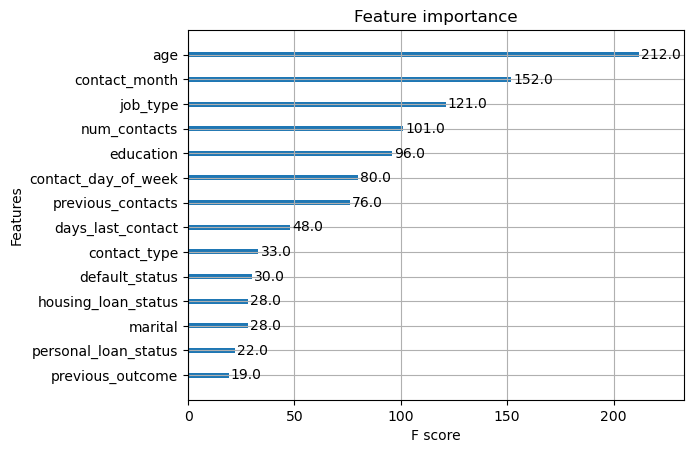

In [31]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)